# Clustering audio à partir des fichiers chroma

On commence ici par étudier le datatset Cross-composer composé d'oeuvres de 11 compositeurs, l'objectif étant d'élargir avec le dataset Cross-era qui pourrait permettre de faire du clustering sur des périodes musicales.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
filename = "cross-composer\chroma-nnls_01_bach.csv"
li_notes = ['time','A','A#','B','C','C#','D','D#','E','F','F#','G','G#']

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\PCAJM\AppData\Local\Temp\ipykernel_7792\2910331894.py:1: SyntaxWarning: invalid escape sequence '\c'
  filename = "cross-composer\chroma-nnls_01_bach.csv"


## Fonctions séparées

### Récupération de chaque fichier en dataframe

In [5]:
dataframe = pd.read_csv(filename)

In [6]:
def to_dataframes(filename):
    """
    Reads a CSV file and returns a dictionary of DataFrame.
    """
    li_notes = ['time','A','A#','B','C','C#','D','D#','E','F','F#','G','G#']
    df = pd.read_csv(filename)
    title = None
    dataf = []
    dataframes = {}
    for i, row in df.iterrows():
        if pd.notna(row[0]):
            if title is not None:
                dataframes[title] = pd.DataFrame(dataf, columns=li_notes)
                dataframes[title].set_index('time', inplace=True)
            title = row[0]
            dataf = []
        else:
            dataf.append(row[1:].tolist())
    
    if title is not None:
        dataframes[title] = pd.DataFrame(dataf, columns=li_notes)
        dataframes[title].set_index('time', inplace=True)
    return dataframes

In [7]:
dataf = to_dataframes(filename)

C:\Users\PCAJM\AppData\Local\Temp\ipykernel_17276\2848940793.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.notna(row[0]):
C:\Users\PCAJM\AppData\Local\Temp\ipykernel_17276\2848940793.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  title = row[0]


In [8]:
dataf.keys()

dict_keys(['01_bach/CrossComp-0056_01_bach_11_bwv_880_in_fmaj.mp3', '01_bach/CrossComp-0057_01_bach_12_bwv_881_in_fmin.mp3', '01_bach/CrossComp-0058_01_bach_13_bwv_882_in_fmaj.mp3', '01_bach/CrossComp-0059_01_bach_14_bwv_883_in_fmin.mp3', '01_bach/CrossComp-0060_01_bach_15_bwv_884_in_gmaj.mp3', '01_bach/CrossComp-0061_01_bach_16_bwv_885_in_gmin.mp3', '01_bach/CrossComp-0062_01_bach_17_bwv_886_in_abmaj.mp3', '01_bach/CrossComp-0063_01_bach_18_bwv_887_in_abmin.mp3', '01_bach/CrossComp-0064_01_bach_19_bwv_888_in_amaj.mp3', '01_bach/CrossComp-0046_01_bach_1_bwv_870_in_cmaj.mp3', '01_bach/CrossComp-0065_01_bach_20_bwv_889_in_amin.mp3', '01_bach/CrossComp-0066_01_bach_21_bwv_890_in_bbmaj.mp3', '01_bach/CrossComp-0067_01_bach_22_bwv_891_in_bbmin.mp3', '01_bach/CrossComp-0068_01_bach_23_bwv_892_in_bmaj.mp3', '01_bach/CrossComp-0069_01_bach_24_bwv_893_in_bmin.mp3', '01_bach/CrossComp-0047_01_bach_2_bwv_871_in_cmin.mp3', '01_bach/CrossComp-0048_01_bach_3_bwv_872_in_cmaj.mp3', '01_bach/CrossComp-

In [9]:
dataf['01_bach/CrossComp-0056_01_bach_11_bwv_880_in_fmaj.mp3']

,A,A#,B,C,C#,D,D#,E,F,F#,G,G#
time,,,,,,,,,,,,
0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
283.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
283.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
283.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
data = dataf['01_bach/CrossComp-0057_01_bach_12_bwv_881_in_fmin.mp3']

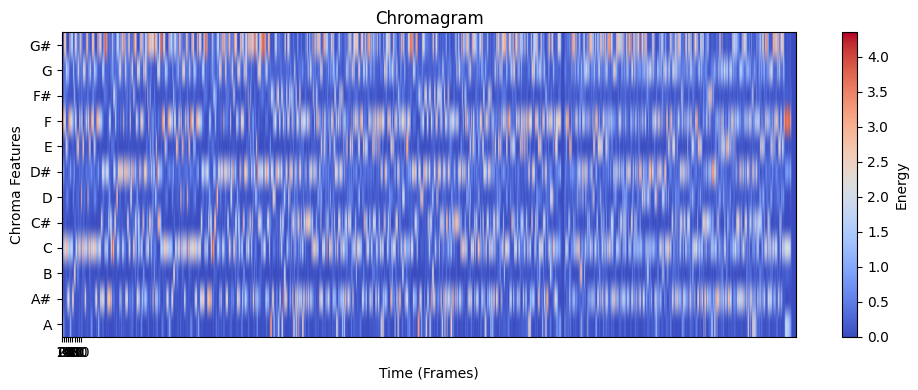

In [11]:
plt.figure(figsize=(10, 4))
plt.imshow(data.T, aspect='auto', origin='lower', cmap='coolwarm')
plt.colorbar(label='Energy')
plt.title('Chromagram')
plt.xlabel('Time (Frames)')
plt.ylabel('Chroma Features')
plt.xticks(ticks=np.arange(0, 100, 10), labels=np.arange(0, 100, 10))  # Ajustez les ticks si nécessaire
plt.yticks(ticks=np.arange(12), labels=data.columns)  # Noms des chroma
plt.tight_layout()
plt.show()

### Fenêtrage

In [12]:
def window_dataframe(df, window_size, hop_length):
    # Nombre de fenêtres possibles
    num_windows = (len(df) - window_size) // hop_length + 1
    windows = []

    for i in range(num_windows):
        start = i * hop_length
        end = start + window_size
        windows.append(df.iloc[start:end].values)  # Ajouter la fenêtre

    return np.array(windows)

In [24]:
li_data = window_dataframe(data,50,10)

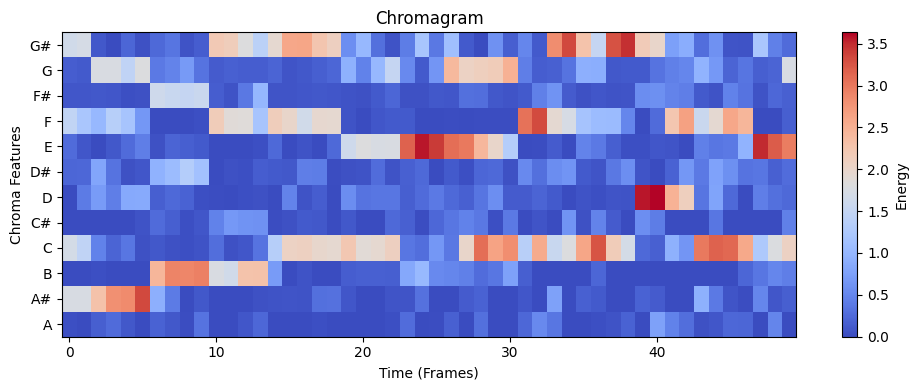

In [25]:
plt.figure(figsize=(10, 4))
plt.imshow(li_data[5].T, aspect='auto', origin='lower', cmap='coolwarm')
plt.colorbar(label='Energy')
plt.title('Chromagram')
plt.xlabel('Time (Frames)')
plt.ylabel('Chroma Features')
#plt.xticks(ticks=np.arange(0, 100, 10), labels=np.arange(0, 100, 10))  # Ajustez les ticks si nécessaire
plt.yticks(ticks=np.arange(12), labels=data.columns)  # Noms des chroma
plt.tight_layout()
plt.show()

## Récupération du fichier et conversion en format libre

In [3]:
def csv_to_windows(filename, window_size, hop_length):
    """
    Reads a CSV file and returns a list of windows.
    """
    li_notes = ['time','A','A#','B','C','C#','D','D#','E','F','F#','G','G#']
    df = pd.read_csv(filename)
    title = None
    dataf = []
    dataframes = {}
    for i, row in df.iterrows():
        if pd.notna(row[0]):
            if title is not None:
                dataframes[title] = pd.DataFrame(dataf, columns=li_notes)
                dataframes[title].set_index('time', inplace=True)
            title = row[0]
            dataf = []
        else:
            dataf.append(row[1:].tolist())
    
    if title is not None:
        dataframes[title] = pd.DataFrame(dataf, columns=li_notes)
        dataframes[title].set_index('time', inplace=True)
    
    windows = []
    for title, df in dataframes.items():
        num_windows = (len(df) - window_size) // hop_length + 1

        for i in range(num_windows):
            start = i * hop_length
            end = start + window_size
            windows.append((title,start,df.iloc[start:end].values))
    
    return windows 

In [11]:
def chromagram(data):
    li_notes = ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#']
    plt.figure(figsize=(10, 4))
    plt.imshow(data.T, aspect='auto', origin='lower', cmap='coolwarm')
    plt.colorbar(label='Energy')
    plt.title('Chromagram')
    plt.xlabel('Time (Frames)')
    plt.ylabel('Chroma Features')
    #plt.xticks(ticks=np.arange(0, 100, 10), labels=np.arange(0, 100, 10))  # Ajustez les ticks si nécessaire
    plt.yticks(ticks=np.arange(12), labels=li_notes)  # Noms des chroma
    plt.tight_layout()
    plt.show()

In [7]:
windows = csv_to_windows(filename, 50, 10)
with open ('windows_bach.pkl', 'wb') as f:
    pickle.dump(windows, f)

C:\Users\PCAJM\AppData\Local\Temp\ipykernel_7792\3506361916.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.notna(row[0]):
C:\Users\PCAJM\AppData\Local\Temp\ipykernel_7792\3506361916.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  title = row[0]


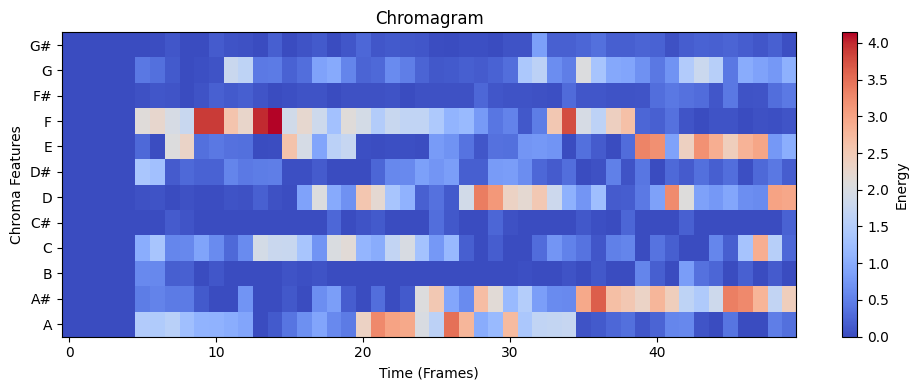

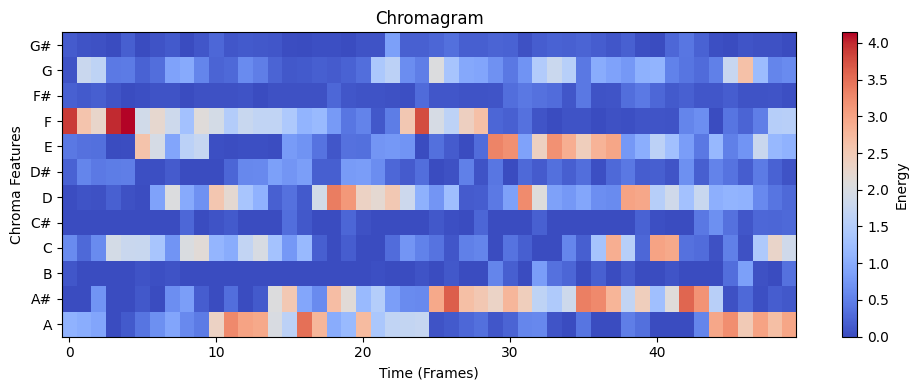

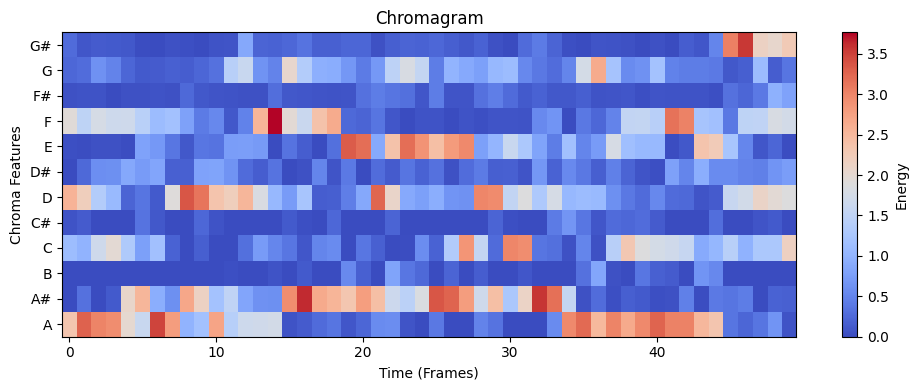

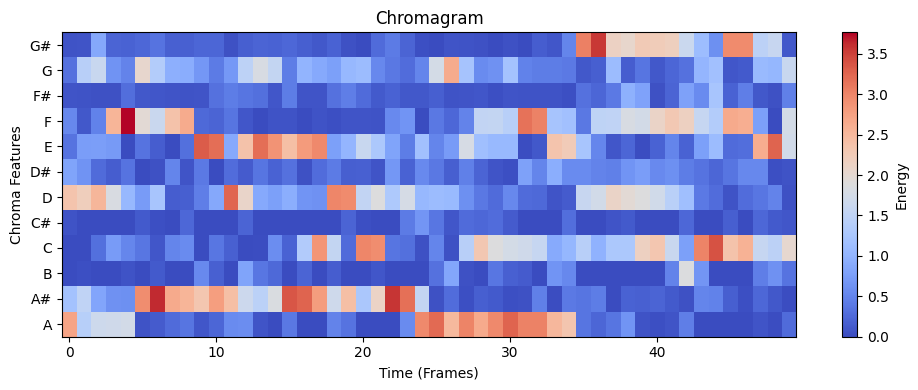

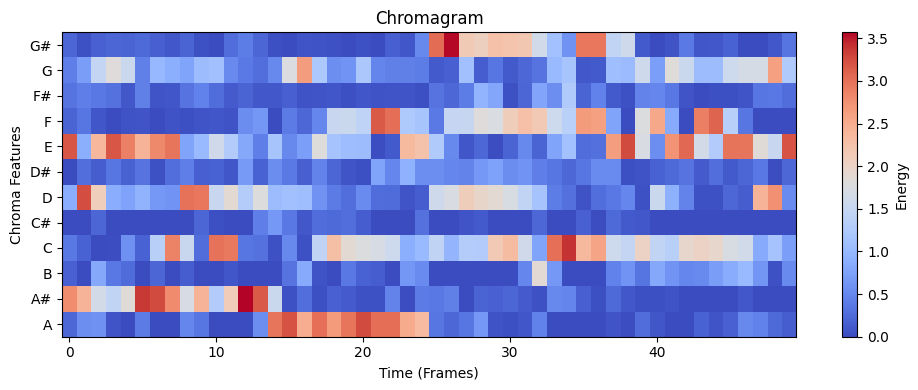

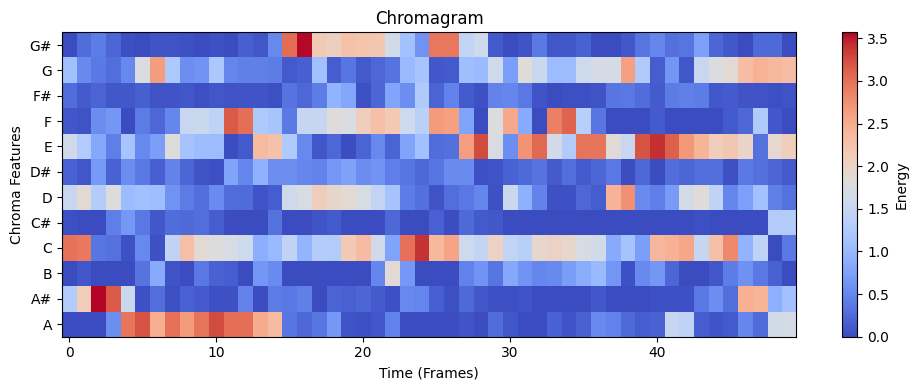

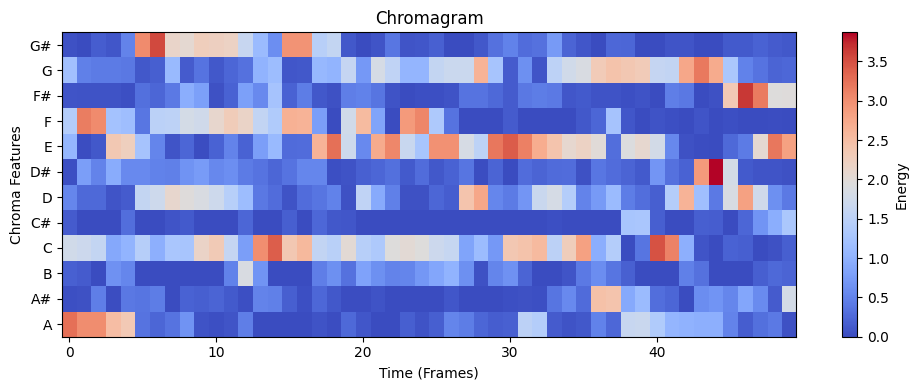

In [15]:
for i in range(7):
    chromagram(windows[i][2])